# Q3 & Q4 Linear Bidding Strategy & Non-Linear Bidding Strategy

#### Import package & data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
# from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer


In [2]:
Training_Set = pd.read_csv(
    '/Users/jasonjiang/Documents/研究生/研究生 下/COMP0124 Multi-agent Artificial Intelligence/Group CW1/@ My Code /we_data/train.csv')
Test_Set = pd.read_csv(
    '/Users/jasonjiang/Documents/研究生/研究生 下/COMP0124 Multi-agent Artificial Intelligence/Group CW1/@ My Code /we_data/test.csv')
Validation_Set = pd.read_csv(
    '/Users/jasonjiang/Documents/研究生/研究生 下/COMP0124 Multi-agent Artificial Intelligence/Group CW1/@ My Code /we_data/validation.csv')


### We have to save all the click/paypric/length data before we Dropping them in the Next section. And we drop the unimportant Dataframe here because random forest regression is very easy to be overfitted

In [3]:

# 在drop之前 选出在后面要用的数据
Train_Click = Training_Set.click
Train_Length = Training_Set.shape[0]
avgCTR = sum(Train_Click) / Train_Length
Train_Click_Sum = sum(Train_Click)
Validation_Length = Validation_Set.shape[0]
Validation_Payprice = Validation_Set.payprice
Validation_Click = Validation_Set.click

### Panda data frames ['click', 'bidid', 'userid', 'IP', 'url', 'urlid', 'slotid', 'useragent', 'slotprice', 'creative', 'bidprice', 'payprice', 'domain', 'slotwidth', 'slotheight'], are drop in this section , those labels consists of too many value, will lead to overfit easily.

In [4]:
Training_Set = Training_Set.drop(
    ['click', 'bidid', 'userid', 'IP', 'url', 'urlid', 'slotid', 'useragent', 'slotprice', 'creative', 'bidprice',
     'payprice', 'domain', 'slotwidth', 'slotheight'], axis=1)
Validation_Set = Validation_Set.drop(
    ['click', 'bidid', 'userid', 'IP', 'url', 'urlid', 'slotid', 'useragent', 'slotprice', 'creative', 'bidprice',
     'payprice', 'domain', 'slotwidth', 'slotheight'], axis=1)

### Before using the sklearn model for prediction, we need to preprocess the data.
#### 1. Eliminate unnecessary data columns to avoid overfitting in the predictions below
#### 2. Convert categorical variable into dummy/indicator variables. We add a column to indicate NaNs.
#### 3. Match the column label between test set / training set using the exchange_dataframe funciton

In [5]:
    Train_Dummy = pd.get_dummies(Training_Set, dummy_na=True,columns=['weekday',
         'hour', 'region', 'city', 'adexchange', 'slotvisibility', 'slotformat','advertiser', 'keypage'])
Train_Dummy = Train_Dummy.join(Training_Set.usertag.astype(str).str.strip('[]').str.get_dummies(','))
Train_Dummy = Train_Dummy.drop(['usertag'], axis=1)
Train_Dummy.fillna(0, inplace=True)


Validation_Dummy = pd.get_dummies(Validation_Set, dummy_na=True,
                                  columns=['weekday', 
    'hour', 'region', 'city', 'adexchange', 'slotvisibility',  'slotformat', 'advertiser', 'keypage'])
Validation_Dummy = Validation_Dummy.join(Validation_Set.usertag.astype(str).str.strip('[]').str.get_dummies(','))
Validation_Dummy = Validation_Dummy.drop(['usertag'], axis=1)
Validation_Dummy.fillna(0, inplace=True)


### Usertag is the most important label for our training and regression.

## but the data amount is very large, pd.get_dummies method will appear memory Error

### therefore we use the MultiLabelBinarizer from sklearn.preprocessing to get dummy variables for usertag

In [6]:

MLB = MultiLabelBinarizer()

Train_Dummy = Train_Dummy.join(
    pd.DataFrame(MLB.fit_transform(Training_Set.pop('usertag')), columns=MLB.classes_, index=Training_Set.index))

Train_Dummy.fillna(Null, inplace=True)


Validation_Dummy = Validation_Dummy.join(
    pd.DataFrame(MLB.fit_transform(Validation_Set.pop('usertag')), columns=MLB.classes_, index=Validation_Set.index))

Validation_Dummy.fillna(Null, inplace=True)



In [7]:
def exchange_dataframe(dataframe_1, dataframe_2):
    return_Frame = pd.DataFrame()
    for i in dataframe_2:
        return_Frame[i] = dataframe_1[i]
    return return_Frame
Validation_with_Trian_Column = exchange_dataframe(Validation_Dummy, Train_Dummy)

###	We fit the model according to the given training data in the trainin set
### Before fitting, we have to use Randomsampler to deal with the imbalanced datasets.
#####   the Randomsampler from imblearn perform random under-sampling without replacement


he ratio is expressed as:
$$
 \alpha_{u s}=N_{r} / N_{m} 
$$
$ N_{m} $ here is the total click number in the training set

Under-sample the majority class(es) by randomly picking samples without replacement.


In [8]:
Under_Sample = RandomUnderSampler(random_state=3, ratio={1: Train_Click_Sum, 0: int(Train_Length/24) })
Train_Dum_UnderSample, Train_Click_UnderSample = Under_Sample.fit_sample(Train_Dummy, Train_Click)
# Train_Click label



### Random forests are not as good at solving regression problems as they do in classification. This is because it does not give a continuous output. When returning, Random forests are not able to make predictions that go beyond the training set data range, which can lead to overfitting when modeling certain data with specific noise. 

### For example we firstly impliment the random forest estimation without specifically setting the constrains. We can hardly control the operation inside the model, it ends up overfitting the labels. Only very few predictions with a relatively high probability, and others predicitons ends up with Zero probability.  Finally leads to very few Bid is cast out (although the CTR is high), and spend only 20% of money. 


#### 控制决策树深度目的是防过拟合. 如果不控制树的深度，直接对样本和特征进行采样，训练多棵完全分支的决策树，最后投票得出结果, 在我们这个标签众多的数据集中非常容易出现过拟合的情况

### The purpose of controlling the depth of the decision tree is to prevent overfitting. If you do not control the depth of the tree,  directly samples the features will easily lead to overfitting.


### Therefore setting the Random Forest parameter is very important , If the maximum depth is deeper, the model will be over-fitting, and a little bit shallower, the model will be under-fitting.

### here we limit the max_depth and the max_feature for the RF Classifier

### Through experimental tests, random forests will over-fit at a depth of around 40.

In [55]:

Logistic_Regression_Result = LogisticRegression(penalty='l1', max_iter=100, C=0.1, tol=0.001, solver='saga',
                                                class_weight='unbalanced')

# Random_Forest_Result = RandomForestClassifier()
# Random_Forest_Result = RandomForestClassifier(max_depth=10 )
# Random_Forest_Result = RandomForestClassifier(max_depth=100,max_features='log2')
Random_Forest_Result = RandomForestClassifier(max_depth=30,max_features='log2')

# max_depth=30 随机森林在深度为40左右会过度拟合

Logistic_Regression_Result.fit(Train_Dum_UnderSample, Train_Click_UnderSample)
Random_Forest_Result.fit(Train_Dum_UnderSample, Train_Click_UnderSample)


/Users/jasonjiang/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [56]:
Click_Prob_Prediction_LR = Logistic_Regression_Result.predict_proba(Validation_with_Trian_Column)
Click_Prob_Prediction_RF = Random_Forest_Result.predict_proba(Validation_with_Trian_Column)

### Calculate the prediected Click Though Rate for both LR(Logistic Regression) and RF(Random Forest Classification)

In [57]:
pCTR_LR = Click_Prob_Prediction_LR[:, 1] / (Click_Prob_Prediction_LR[:, 1] + (1 - Click_Prob_Prediction_LR[:, 1]) / (Train_Length/24) * Train_Length)
pCTR_RF = Click_Prob_Prediction_RF[:, 1] / (Click_Prob_Prediction_RF[:, 1] + (1 - Click_Prob_Prediction_RF[:, 1]) / (Train_Length/24) * Train_Length)



In [58]:

def criterion_calculation(dataframe, index, base_bid, click_num, spend, impression):
    dataframe.loc[index, 'Base_Bid'] = base_bid
    dataframe.loc[index, 'clicks'] = click_num
    dataframe.loc[index, 'Spend'] = spend / 1000
    dataframe.loc[index, 'Impression'] = impression
    dataframe.loc[index, 'CTR'] = click_num / impression
    dataframe.loc[index, 'eCPC'] = spend / click_num
    dataframe.loc[index, 'CPM'] = spend * 1000 / impression



# Q3 Linear Bidding Strategy:

In order to help advertisers forming a bidding strategy for
placing their ads, linear models are a widely used method:

$$\quad b i d= basebid \frac{p C T R}{\operatorname{avg} C T R}$$

#### base-bid
is the independent variable which we can variate
it in the experiments, we also called it the tuning parameter.
And we increase the tuning parameter bit by bit as inputs
to the linear bidding formula above.

#### Click-Through-Rate(CTR) 
as  mentioned in the Terminology section is generally calculated by the following formula:
$$
C T R=\frac{\text { Total number of clicks }}{\text { Total number of impressions }}
$$

#### avgCTR 
is the average CTR, which is approximatly calculated by all clicks in train set divided by the length of the train set:

#### pCTR
is the most important parameter which represents the predicted click through probability for the impression in the test set. pCTR is determined by a prediction model, and we can use the commonly use machine learning xtechnique to do the prediction. Here we choose Logistic Regression and Random Forest Classification to do the Regression.

## tuning the base bid for Linear Bidding Strategy by Logistic Regression 



In [59]:
Linear_Bidding_LR = pd.DataFrame(columns=['Base_Bid', 'Impression', 'Spend', 'clicks'])
Base_Bid_Index = 0

for Base_Bid in np.arange(5, 300, 5):
    Click_Number = 0
    Remaining = True
    Impression = 0
    Spend = 0
    Base_Bid_Index += 1
    for i in range(Validation_Length):
        Bid_Price = Base_Bid * (pCTR_LR[i] / avgCTR)
        if Bid_Price >= Validation_Payprice[i] and Remaining:
            Spend = Spend + Validation_Payprice[i]
            if Spend > 6250000:
                Spend = Spend - Validation_Payprice[i]
                Remaining = False
                break
            Click_Number = Click_Number + Validation_Click[i]
            Impression = Impression + 1

    criterion_calculation(Linear_Bidding_LR, Base_Bid_Index, Base_Bid, Click_Number, Spend, Impression)

## tuning the base bid for Linear Bidding Strategy by Random Forest Classification



In [60]:

Linear_Bidding_RF = pd.DataFrame(columns=['Base_Bid', 'Impression', 'Spend', 'clicks'])
Base_Bid_Index = 0
for Base_Bid in np.arange(5, 300, 5):
    Click_Number = 0
    Remaining = True
    Impression = 0
    Spend = 0
    Base_Bid_Index += 1
    for i in range(Validation_Length):
        Bid_Price = Base_Bid * (pCTR_RF[i] / avgCTR)
        #         print(Bid_Price) #会卡
        if Bid_Price >= Validation_Payprice[i] and Remaining:
            Spend = Spend + Validation_Payprice[i]
            if Spend > 6250000:
                Spend = Spend - Validation_Payprice[i]
                Remaining = False
                break
            Click_Number = Click_Number + Validation_Click[i]
            Impression = Impression + 1

    criterion_calculation(Linear_Bidding_RF, Base_Bid_Index, Base_Bid, Click_Number, Spend, Impression)

In [92]:
Linear_Bidding_LR

,Base_Bid,Impression,Spend,clicks,CTR,eCPC,CPM
1,5.0,5183.0,110.388,74.0,0.010419,2044.222222,21298.089909
2,10.0,12463.0,279.268,87.0,0.005376,4168.179104,22407.766990
3,15.0,20561.0,493.738,92.0,0.003502,6857.472222,24013.326200
4,20.0,29087.0,739.656,101.0,0.002785,9131.555556,25429.092034
5,25.0,37354.0,1001.52,109.0,0.002383,11253.044944,26811.613214
6,30.0,45763.0,1291.42,114.0,0.002054,13738.468085,28219.653432
7,35.0,54131.0,1599.06,120.0,0.001847,15990.640000,29540.632909
8,40.0,62001.0,1920.76,128.0,0.001742,17784.824074,30979.516459
9,45.0,69554.0,2265.76,132.0,0.001610,20230.000000,32575.552808
10,50.0,77198.0,2649.27,137.0,0.001516,22643.341880,34317.870929


In [95]:
# Linear_Bidding_LR.tail()
max(Linear_Bidding_LR.clicks)


161.0

In [97]:
Linear_Bidding_RF

,Base_Bid,Impression,Spend,clicks,CTR,eCPC,CPM
1,5.0,6176.0,100.542,54.0,0.005181,3141.937500,16279.468912
2,10.0,14937.0,359.647,79.0,0.003816,6309.596491,24077.592555
3,15.0,23617.0,686.934,92.0,0.002964,9813.342857,29086.420799
4,20.0,30868.0,936.697,97.0,0.002430,12489.293333,30345.244266
5,25.0,38022.0,1206.68,105.0,0.002183,14538.313253,31736.363158
6,30.0,46499.0,1507.98,111.0,0.001914,16943.561798,32430.310329
7,35.0,55200.0,1817.71,114.0,0.001667,19757.673913,32929.456522
8,40.0,63228.0,2115.46,120.0,0.001550,21586.336735,33457.661163
9,45.0,70193.0,2388.4,127.0,0.001496,22746.657143,34026.170701
10,50.0,76681.0,2649.36,132.0,0.001435,24085.090909,34550.410141


In [98]:
max(Linear_Bidding_RF.clicks)

162.0

# Plotting for the Linear Bidding Strategy

In [99]:

Predicted_Clicks_RF_Linear = Linear_Bidding_RF[['Base_Bid', 'clicks']].astype(float)
Predicted_CTR_RF_Linear = Linear_Bidding_RF[['Base_Bid', 'CTR']].astype(float)
Predicted_Clicks_LR_Linear = Linear_Bidding_LR[['Base_Bid', 'clicks']].astype(float)
Predicted_CTR_LR_Linear = Linear_Bidding_LR[['Base_Bid', 'CTR']].astype(float)


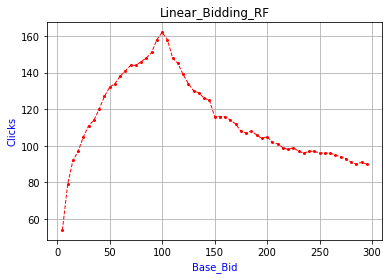

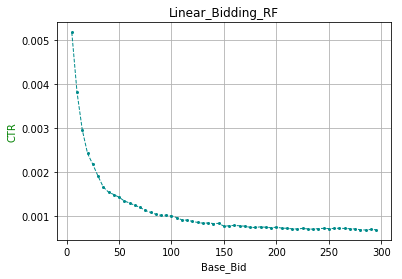

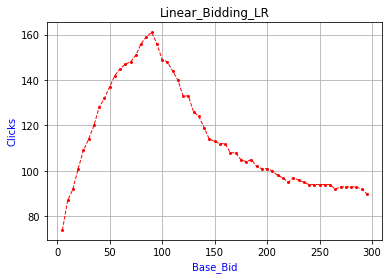

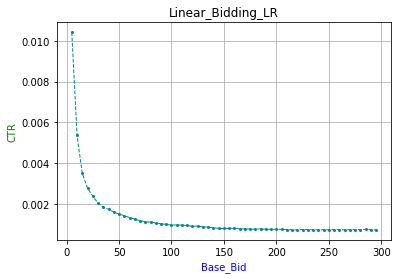

In [100]:

plt.plot(Predicted_Clicks_RF_Linear.Base_Bid, Predicted_Clicks_RF_Linear.clicks, color='red', marker='o',
         linestyle='dashed',
         linewidth=1,
         markersize=2)
plt.xlabel('Base_Bid', color='b')
plt.ylabel('Clicks', color='b')
plt.title("Linear_Bidding_RF")
plt.grid(True)
plt.show()

plt.plot(Predicted_CTR_RF_Linear.Base_Bid, Predicted_CTR_RF_Linear.CTR, color='darkcyan', marker='o',
         linestyle='dashed', linewidth=1,
         markersize=2)
plt.xlabel('Base_Bid')
plt.ylabel('CTR', color='g')
plt.title("Linear_Bidding_RF")
plt.grid(True)
plt.show()

plt.plot(Predicted_Clicks_LR_Linear.Base_Bid, Predicted_Clicks_LR_Linear.clicks, color='red', marker='o',
         linestyle='dashed',
         linewidth=1,
         markersize=2)
plt.xlabel('Base_Bid', color='b')
plt.ylabel('Clicks', color='b')
plt.title("Linear_Bidding_LR")
plt.grid(True)
plt.show()

plt.plot(Predicted_CTR_LR_Linear.Base_Bid, Predicted_CTR_LR_Linear.CTR, color='darkcyan', marker='o',
         linestyle='dashed', linewidth=1,
         markersize=2)
plt.xlabel('Base_Bid', color='b')
plt.ylabel('CTR', color='green')
plt.title("Linear_Bidding_LR")
plt.grid(True)
plt.show()


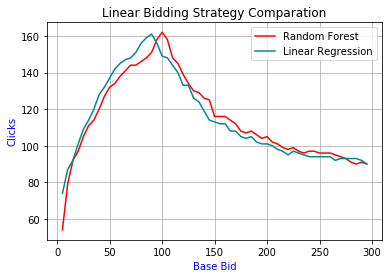

In [101]:
plt.title('Linear Bidding Strategy Comparation')
plt.plot(Predicted_Clicks_RF_Linear.Base_Bid, Predicted_Clicks_RF_Linear.clicks, color='red', label='Random Forest')
# plt.plot(Predicted_CTR_RF_Linear.Base_Bid, Predicted_CTR_RF_Linear.CTR, color='red', label='Random Forest')
plt.plot(Predicted_Clicks_LR_Linear.Base_Bid, Predicted_Clicks_LR_Linear.clicks, color='darkcyan',
         label='Linear Regression')
# plt.plot(Predicted_CTR_LR_Linear.Base_Bid, Predicted_CTR_LR_Linear.CTR, color='darkcyan', label='Linear Regression')
plt.legend()  #
plt.grid(True)

plt.xlabel('Base Bid', color='b')
plt.ylabel('Clicks', color='b')
plt.show()

## The best scenario is shown below

# Q4 Non-Linear Bidding Strategy:

## Q4.1 Quadratic bidding

### Bid_Price = Base_Bid * (pCTR_LR[i] / avgCTR)**2

## tuning the base bid for Non-Linear Bidding Strategy by Logistic Regression 



In [66]:

NonLinear_1_LR = pd.DataFrame(columns=['Base_Bid', 'Impression', 'Spend', 'clicks'])

Base_Bid_Index = 0

for Base_Bid in np.arange(5, 300, 5):
    Click_Number = 0
    Remaining = True
    Impression = 0
    Spend = 0
    Base_Bid_Index += 1
    for i in range(Validation_Length):
        Bid_Price = Base_Bid * (pCTR_LR[i] / avgCTR)**2
        if Bid_Price >= Validation_Payprice[i] and Remaining:
            Spend = Spend + Validation_Payprice[i]
            if Spend > 6250000:
                Spend = Spend - Validation_Payprice[i]
                Remaining = False
                break
            Click_Number = Click_Number + Validation_Click[i]
            Impression = Impression + 1

    criterion_calculation(NonLinear_1_LR, Base_Bid_Index, Base_Bid, Click_Number, Spend, Impression)


NonLinear_1_RF = pd.DataFrame(columns=['Base_Bid', 'Impression', 'Spend', 'clicks'])

Base_Bid_Index = 0
for Base_Bid in np.arange(5, 300, 5):
    Click_Number = 0
    Remaining = True
    Impression = 0
    Spend = 0
    Base_Bid_Index += 1
    for i in range(Validation_Length):
        Bid_Price = Base_Bid * (pCTR_RF[i] / avgCTR)**2
        #         print(Bid_Price) #会卡
        if Bid_Price >= Validation_Payprice[i] and Remaining:
            Spend = Spend + Validation_Payprice[i]
            if Spend > 6250000:
                Spend = Spend - Validation_Payprice[i]
                Remaining = False
                break
            Click_Number = Click_Number + Validation_Click[i]
            Impression = Impression + 1

    criterion_calculation(NonLinear_1_RF, Base_Bid_Index, Base_Bid, Click_Number, Spend, Impression)


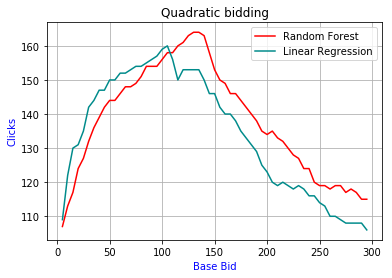

In [113]:
Predicted_Clicks_RF_NonLinear1 = NonLinear_1_RF[['Base_Bid', 'clicks']].astype(float)
Predicted_CTR_RF_NonLinear1 = NonLinear_1_RF[['Base_Bid', 'CTR']].astype(float)
Predicted_Clicks_LR_NonLinear1 = NonLinear_1_LR[['Base_Bid', 'clicks']].astype(float)
Predicted_CTR_LR_NonLinear1 = NonLinear_1_LR[['Base_Bid', 'CTR']].astype(float)

plt.title('Quadratic bidding')
plt.plot(Predicted_Clicks_RF_NonLinear1.Base_Bid, Predicted_Clicks_RF_NonLinear1.clicks, color='red', label='Random Forest')
# plt.plot(Predicted_CTR_RF_NonLinear1.Base_Bid, Predicted_CTR_RF_NonLinear1.CTR, color='red', label='Random Forest')
plt.plot(Predicted_Clicks_LR_NonLinear1.Base_Bid, Predicted_Clicks_LR_NonLinear1.clicks, color='darkcyan',
         label='Linear Regression')
# plt.plot(Predicted_CTR_LR_NonLinear1.Base_Bid, Predicted_CTR_LR_NonLinear1.CTR, color='darkcyan', label='Linear Regression')
plt.legend()  #
plt.grid(True)

plt.xlabel('Base Bid', color='b')
plt.ylabel('Clicks', color='b')
plt.show()


In [114]:
max(Predicted_Clicks_RF_NonLinear1.clicks)


164.0

In [115]:
max(Predicted_Clicks_LR_NonLinear1.clicks)

160.0

## Q4.2 Squre root bidding Strategy

   ###     Bid_Price = Base_Bid * np.sqrt(pCTR_LR[i] / avgCTR)



In [68]:


NonLinear_2_LR = pd.DataFrame(columns=['Base_Bid', 'Impression', 'Spend', 'clicks'])

Base_Bid_Index = 0

for Base_Bid in np.arange(5, 300, 5):
    Click_Number = 0
    Remaining = True
    Impression = 0
    Spend = 0
    Base_Bid_Index += 1
    for i in range(Validation_Length):
        Bid_Price = Base_Bid * np.sqrt(pCTR_LR[i] / avgCTR)
        if Bid_Price >= Validation_Payprice[i] and Remaining:
            Spend = Spend + Validation_Payprice[i]
            if Spend > 6250000:
                Spend = Spend - Validation_Payprice[i]
                Remaining = False
                break
            Click_Number = Click_Number + Validation_Click[i]
            Impression = Impression + 1

    criterion_calculation(NonLinear_2_LR, Base_Bid_Index, Base_Bid, Click_Number, Spend, Impression)


NonLinear_2_RF = pd.DataFrame(columns=['Base_Bid', 'Impression', 'Spend', 'clicks'])

Base_Bid_Index = 0
for Base_Bid in np.arange(5, 300, 5):
    Click_Number = 0
    Remaining = True
    Impression = 0
    Spend = 0
    Base_Bid_Index += 1
    for i in range(Validation_Length):
        Bid_Price = Base_Bid * np.sqrt(pCTR_RF[i] / avgCTR)
        #         print(Bid_Price) #会卡
        if Bid_Price >= Validation_Payprice[i] and Remaining:
            Spend = Spend + Validation_Payprice[i]
            if Spend > 6250000:
                Spend = Spend - Validation_Payprice[i]
                Remaining = False
                break
            Click_Number = Click_Number + Validation_Click[i]
            Impression = Impression + 1

    criterion_calculation(NonLinear_2_RF, Base_Bid_Index, Base_Bid, Click_Number, Spend, Impression)


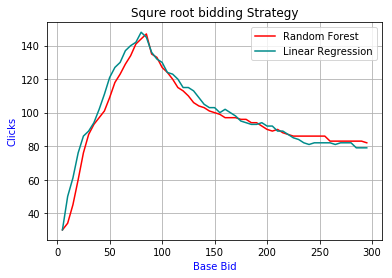

In [118]:
Predicted_Clicks_RF_NonLinear2 = NonLinear_2_RF[['Base_Bid', 'clicks']].astype(float)
Predicted_CTR_RF_NonLinear2 = NonLinear_2_RF[['Base_Bid', 'CTR']].astype(float)
Predicted_Clicks_LR_NonLinear2 = NonLinear_2_LR[['Base_Bid', 'clicks']].astype(float)
Predicted_CTR_LR_NonLinear2 = NonLinear_2_LR[['Base_Bid', 'CTR']].astype(float)

plt.title('Squre root bidding Strategy')
plt.plot(Predicted_Clicks_RF_NonLinear2.Base_Bid, Predicted_Clicks_RF_NonLinear2.clicks, color='red', label='Random Forest')
# plt.plot(Predicted_CTR_RF_NonLinear2.Base_Bid, Predicted_CTR_RF_NonLinear2.CTR, color='red', label='Random Forest')
plt.plot(Predicted_Clicks_LR_NonLinear2.Base_Bid, Predicted_Clicks_LR_NonLinear2.clicks, color='darkcyan',
         label='Linear Regression')
# plt.plot(Predicted_CTR_LR_NonLinear2.Base_Bid, Predicted_CTR_LR_NonLinear2.CTR, color='darkcyan', label='Linear Regression')
plt.legend()  #
plt.grid(True)

plt.xlabel('Base Bid', color='b')
plt.ylabel('Clicks', color='b')
plt.show()

## Q4.3 Exp bidding Strategy

###  Bid_Price = Base_Bid * np.exp(pCTR_LR[i] / avgCTR/3)



In [89]:

NonLinear_3_LR = pd.DataFrame(columns=['Base_Bid', 'Impression', 'Spend', 'clicks'])

Base_Bid_Index = 0

for Base_Bid in np.arange(5, 300, 5):
    Click_Number = 0
    Remaining = True
    Impression = 0
    Spend = 0
    Base_Bid_Index += 1
    for i in range(Validation_Length):
        Bid_Price = Base_Bid * np.exp(pCTR_LR[i] / avgCTR/3)
        if Bid_Price >= Validation_Payprice[i] and Remaining:
            Spend = Spend + Validation_Payprice[i]
            if Spend > 6250000:
                Spend = Spend - Validation_Payprice[i]
                Remaining = False
                break
            Click_Number = Click_Number + Validation_Click[i]
            Impression = Impression + 1

    criterion_calculation(NonLinear_3_LR, Base_Bid_Index, Base_Bid, Click_Number, Spend, Impression)


NonLinear_3_RF = pd.DataFrame(columns=['Base_Bid', 'Impression', 'Spend', 'clicks'])

Base_Bid_Index = 0
for Base_Bid in np.arange(5, 300, 5):
    Click_Number = 0
    Remaining = True
    Impression = 0
    Spend = 0
    Base_Bid_Index += 1
    for i in range(Validation_Length):
        Bid_Price = Base_Bid * np.exp(pCTR_RF[i] / avgCTR/3)
        #         print(Bid_Price) #会卡
        if Bid_Price >= Validation_Payprice[i] and Remaining:
            Spend = Spend + Validation_Payprice[i]
            if Spend > 6250000:
                Spend = Spend - Validation_Payprice[i]
                Remaining = False
                break
            Click_Number = Click_Number + Validation_Click[i]
            Impression = Impression + 1

    criterion_calculation(NonLinear_3_RF, Base_Bid_Index, Base_Bid, Click_Number, Spend, Impression)


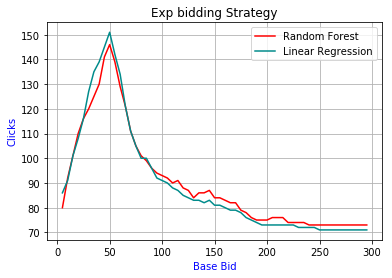

In [127]:
Predicted_Clicks_RF_NonLinear3 = NonLinear_3_RF[['Base_Bid', 'clicks']].astype(float)
Predicted_CTR_RF_NonLinear3 = NonLinear_3_RF[['Base_Bid', 'CTR']].astype(float)
Predicted_Clicks_LR_NonLinear3 = NonLinear_3_LR[['Base_Bid', 'clicks']].astype(float)
Predicted_CTR_LR_NonLinear3 = NonLinear_3_LR[['Base_Bid', 'CTR']].astype(float)

plt.title('Exp bidding Strategy')
plt.plot(Predicted_Clicks_RF_NonLinear3.Base_Bid, Predicted_Clicks_RF_NonLinear3.clicks, color='red', label='Random Forest')
# plt.plot(Predicted_CTR_RF_NonLinear3.Base_Bid, Predicted_CTR_RF_NonLinear3.CTR, color='red', label='Random Forest')
plt.plot(Predicted_Clicks_LR_NonLinear3.Base_Bid, Predicted_Clicks_LR_NonLinear3.clicks, color='darkcyan',
         label='Linear Regression')
# plt.plot(Predicted_CTR_LR_NonLinear3.Base_Bid, Predicted_CTR_LR_NonLinear3.CTR, color='darkcyan', label='Linear Regression')
plt.legend()  #
plt.grid(True)

plt.xlabel('Base Bid', color='b')
plt.ylabel('Clicks', color='b')
plt.show()


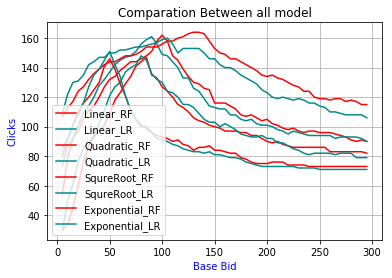

In [130]:
plt.title('Comparation Between all model')
plt.plot(Predicted_Clicks_RF_Linear.Base_Bid, Predicted_Clicks_RF_Linear.clicks, color='red', label='Linear_RF')
# plt.plot(Predicted_CTR_RF_Linear.Base_Bid, Predicted_CTR_RF_Linear.CTR, color='red', label='Random Forest')
plt.plot(Predicted_Clicks_LR_Linear.Base_Bid, Predicted_Clicks_LR_Linear.clicks, color='darkcyan',
         label='Linear_LR')
# plt.plot(Predicted_CTR_LR_Linear.Base_Bid, Predicted_CTR_LR_Linear.CTR, color='darkcyan', label='Linear Regression')

plt.xlabel('Base Bid', color='b')
plt.ylabel('Clicks', color='b')




plt.plot(Predicted_Clicks_RF_NonLinear1.Base_Bid, Predicted_Clicks_RF_NonLinear1.clicks, color='red', label='Quadratic_RF')
# plt.plot(Predicted_CTR_RF_NonLinear1.Base_Bid, Predicted_CTR_RF_NonLinear1.CTR, color='red', label='Random Forest')
plt.plot(Predicted_Clicks_LR_NonLinear1.Base_Bid, Predicted_Clicks_LR_NonLinear1.clicks, color='darkcyan',
         label='Quadratic_LR')
# plt.plot(Predicted_CTR_LR_NonLinear1.Base_Bid, Predicted_CTR_LR_NonLinear1.CTR, color='darkcyan', label='Linear Regression')




plt.plot(Predicted_Clicks_RF_NonLinear2.Base_Bid, Predicted_Clicks_RF_NonLinear2.clicks, color='red', label='SqureRoot_RF')
# plt.plot(Predicted_CTR_RF_NonLinear2.Base_Bid, Predicted_CTR_RF_NonLinear2.CTR, color='red', label='Random Forest')
plt.plot(Predicted_Clicks_LR_NonLinear2.Base_Bid, Predicted_Clicks_LR_NonLinear2.clicks, color='darkcyan',
         label='SqureRoot_LR')
# plt.plot(Predicted_CTR_LR_NonLinear2.Base_Bid, Predicted_CTR_LR_NonLinear2.CTR, color='darkcyan', label='Linear Regression')




plt.plot(Predicted_Clicks_RF_NonLinear3.Base_Bid, Predicted_Clicks_RF_NonLinear3.clicks, color='red', label='Exponential_RF')
# plt.plot(Predicted_CTR_RF_NonLinear3.Base_Bid, Predicted_CTR_RF_NonLinear3.CTR, color='red', label='Random Forest')
plt.plot(Predicted_Clicks_LR_NonLinear3.Base_Bid, Predicted_Clicks_LR_NonLinear3.clicks, color='darkcyan',
         label='Exponential_LR')
# plt.plot(Predicted_CTR_LR_NonLinear3.Base_Bid, Predicted_CTR_LR_NonLinear3.CTR, color='darkcyan', label='Linear Regression')
plt.legend()  #
plt.grid(True)



plt.xlabel('Base Bid', color='b')
plt.ylabel('Clicks', color='b')
plt.show()



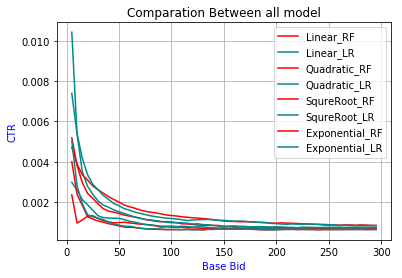

In [132]:
plt.title('Comparation Between all model')
plt.plot(Predicted_CTR_RF_Linear.Base_Bid, Predicted_CTR_RF_Linear.CTR, color='red', label='Linear_RF')
plt.plot(Predicted_CTR_LR_Linear.Base_Bid, Predicted_CTR_LR_Linear.CTR, color='darkcyan',
         label='Linear_LR')

plt.xlabel('Base Bid', color='b')
plt.ylabel('CTR', color='b')

plt.plot(Predicted_CTR_RF_NonLinear1.Base_Bid, Predicted_CTR_RF_NonLinear1.CTR, color='red', label='Quadratic_RF')
plt.plot(Predicted_CTR_LR_NonLinear1.Base_Bid, Predicted_CTR_LR_NonLinear1.CTR, color='darkcyan',
         label='Quadratic_LR')

plt.plot(Predicted_CTR_RF_NonLinear2.Base_Bid, Predicted_CTR_RF_NonLinear2.CTR, color='red', label='SqureRoot_RF')
plt.plot(Predicted_CTR_LR_NonLinear2.Base_Bid, Predicted_CTR_LR_NonLinear2.CTR, color='darkcyan',
         label='SqureRoot_LR')

plt.plot(Predicted_CTR_RF_NonLinear3.Base_Bid, Predicted_CTR_RF_NonLinear3.CTR, color='red', label='Exponential_RF')
plt.plot(Predicted_CTR_LR_NonLinear3.Base_Bid, Predicted_CTR_LR_NonLinear3.CTR, color='darkcyan',
         label='Exponential_LR')
plt.legend()  #
plt.grid(True)

plt.xlabel('Base Bid', color='b')
plt.ylabel('CTR', color='b')
plt.show()


